In [10]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import cv2
import matplotlib.pyplot as plt
import PIL.Image as Image

In [11]:
DATA_DIR = './data/eyes/'
x_train_dir = "train/imagepng"
y_train_dir = "train/labelpng"

x_valid_dir = "train/imagepng"
y_valid_dir = "train/labelpng"

x_test_dir = "test/imagepng"
y_test_dir = "train/labelpng"

In [12]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [13]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [14]:
class Dataset(BaseDataset):
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        #self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.class_values = [255]
        #print(self.class_values)
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        if self.augmentation!=None:
            i=i%len(self.ids)
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #扩充边界 把565*584的图片变为576*584的图片
        image=cv2.copyMakeBorder(image, 0,0,5,6,cv2.BORDER_CONSTANT,value=[0,0,0]) 
        #上下裁掉4个像素
        image = image[4:580, :, :]
        # #转为灰度图
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # #第三维为1
        # image = np.expand_dims(image, axis=2)
        
        mask = cv2.imread(self.masks_fps[i], 0)
        #扩充边界 把565*584的图片变为576*584的图片
        mask=cv2.copyMakeBorder(mask, 0,0,5,6,cv2.BORDER_CONSTANT,value=[0])
        #上下裁掉4个像素
        mask = mask[4:580, :, ]
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        # print(masks)
        mask = np.stack(masks, axis=-1).astype('float')


        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            #把(3, 608, 576)大小的图片取出第二通道，变为(1，608, 576)大小
            #image = np.expand_dims(image[1], axis=0)
                
        
        return image, mask
        
    def __len__(self):
        if self.augmentation!=None:
            return 4*len(self.ids)
        return len(self.ids)

### Augmentations

In [15]:
import albumentations as albu
def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        # albu.PadIfNeeded(min_height=576, min_width=576, always_apply=True, border_mode=0,value=0),
        # albu.RandomCrop(height=576, width=576, always_apply=True),
        albu.ShiftScaleRotate(
            scale_limit=0.3,
            rotate_limit=(-45, 45),
            shift_limit=0.3,
            p=1,
            border_mode=0,
        ),
        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),
        albu.OneOf(
            [
                albu.CLAHE(p=0.5),
                albu.RandomBrightnessContrast(p=0.5),
                albu.RandomGamma(p=0.5),
            ],
            p=0.5,
        ),
        albu.OneOf(
            [
                albu.Sharpen(p=0.5),
                albu.Blur(blur_limit=3, p=0.5),
                albu.MotionBlur(blur_limit=3, p=0.5),
            ],
            p=0.5,
        ),
        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=0.5),
                albu.HueSaturationValue(p=0.5),
            ],
            p=0.5,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        #albu.PadIfNeeded(608, 576)
        #albu.Resize(608, 576),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(mean, std):    
    _transform = [
        #根据mean和std对数据进行标准化
        albu.Normalize(mean=mean, std=std),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

80
(576, 576, 3)
(576, 576, 1)


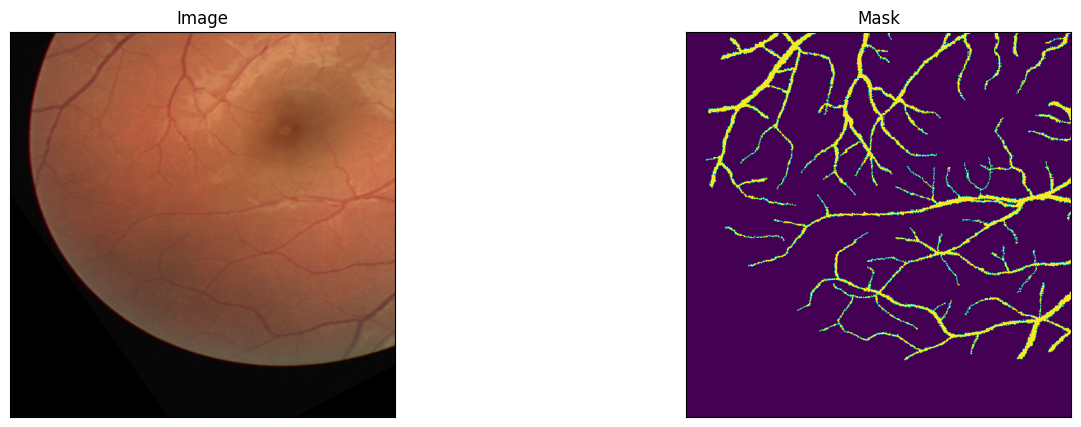

(576, 576, 3)
(576, 576, 1)


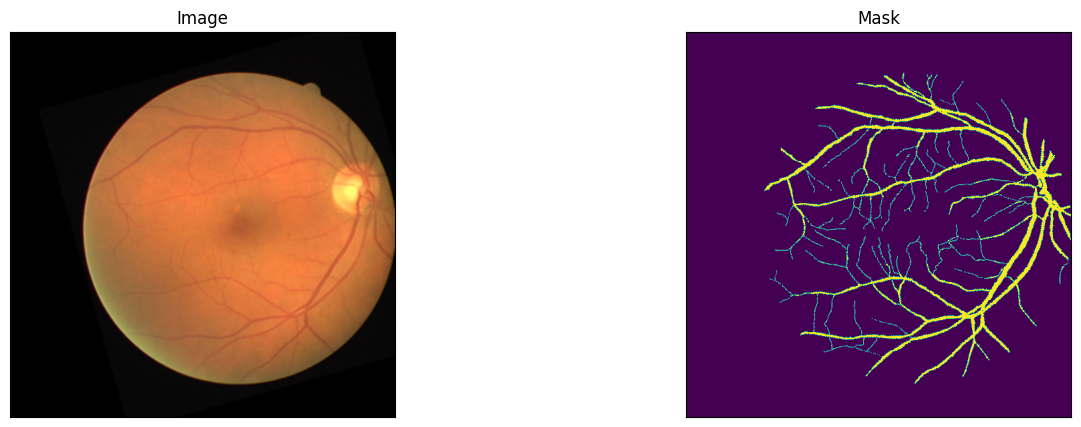

In [16]:
#### Visualize resulted augmented images and masks
augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
)
print(len(augmented_dataset))
# same image with different random transforms
for i in range(2):
    image, mask = augmented_dataset[i]
    print(image.shape)
    print(mask.shape)
    visualize(image=image, mask=mask)

标准化

Compute mean and variance for training data.
20
标准化前 [0.49449528 0.26900229 0.16137745] [0.3330333  0.17922099 0.0994361 ]
Compute mean and variance for training data.
20
Compute mean and variance for training data.
20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


标准化后 [1.95732875e-08 1.95732875e-08 1.95732875e-08] [1.01244279 1.01244279 1.01244279]


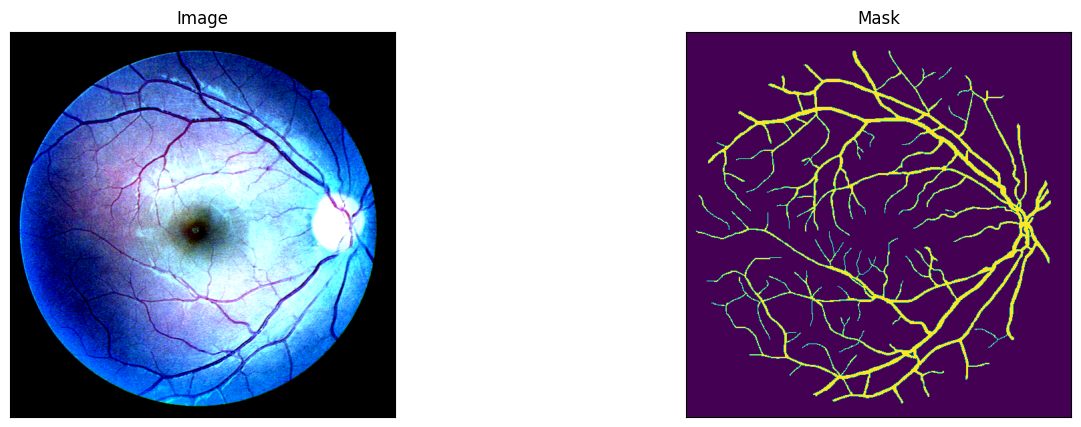

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


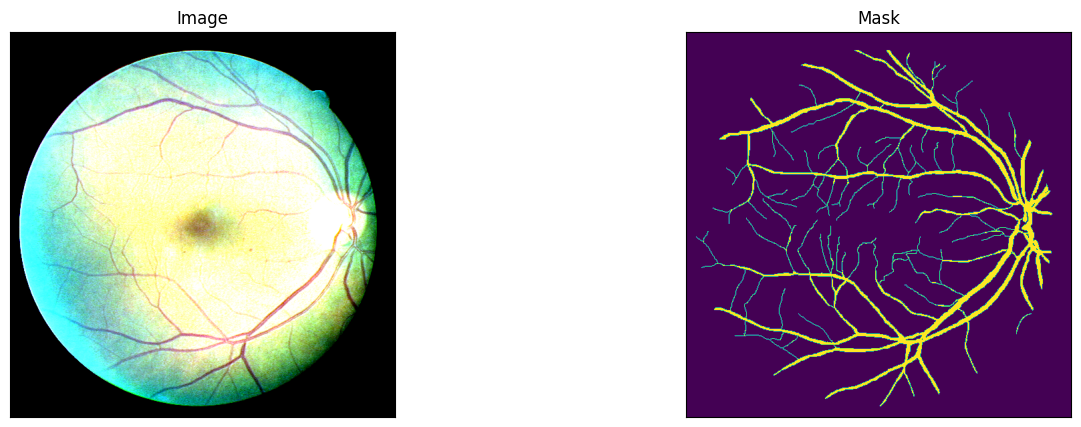

In [17]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir)

#计算std和mean
import torch
def getStat(train_data):
    print("Compute mean and variance for training data.")
    print(len(train_data))
    
    all_mean = np.zeros(3)
    all_std = np.zeros(3)
    for image,mask in train_data:
        #利用cv2计算每个通道的均值和方差
        mean,std=cv2.meanStdDev(image)
        #加入总的均值和方差中
        all_mean += mean.squeeze()
        all_std += std.squeeze()
    all_mean/=(len(train_data)*255)
    all_std/=(len(train_data)*255)
    return all_mean, all_std

mean,std=getStat(dataset)

print("标准化前",mean,std)

dataset = Dataset(x_train_dir, y_train_dir, 
                preprocessing=get_preprocessing(mean,std))
print("标准化后",getStat(dataset)[0]*255,getStat(dataset)[1]*255)

#查看标准化后的图片
for i in range(2):
    image, mask = dataset[i]
    #逆to_tensor
    image = image.transpose(1, 2, 0)
    mask = mask.transpose(1, 2, 0)
    visualize(image=image, mask=mask)

## Create model and train

In [18]:
import numpy as np
import segmentation_models_pytorch as smp

In [19]:
#preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS,)
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(mean,std),
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    #augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(mean,std),
)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)

valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

In [20]:
#查看train_loader的数据
for i, (data, target) in enumerate(train_loader):
    print(data.shape)
    print(target.shape)
    break

torch.Size([1, 3, 576, 576])
torch.Size([1, 1, 576, 576])


In [21]:
ENCODER = 'tu-efficientnetv2_rw_t'
#ENCODER = 'timm-regnetx_002'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['eye']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'
IN_CHANNELS=3,
# create segmentation model with pretrained encoder
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=None, 
    in_channels=IN_CHANNELS[0],
    classes=1, 
    activation=ACTIVATION,
)
try:
    model=torch.load(f'models/best_{model.name}_{IN_CHANNELS[0]}.pth')
    print(f"导入本地模型models/best_{model.name}_{IN_CHANNELS[0]}成功")
except:
    print("导入本地模型失败")

导入本地模型models/best_unetplusplus-tu-efficientnetv2_rw_t_3成功


In [22]:
from segmentation_models_pytorch import utils

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.AdamW([ 
    dict(params=model.parameters(), lr=0.001),
])

In [23]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [24]:
# train model for 40 epochs
#定义学习率调整策略
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3,verbose=True)
min_loss = 100
best_epoch = 0

for epoch in range(0, 5000):
    
    print('\nEpoch: {}'.format(epoch))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    
    # do something (save model, change lr, etc.)
    if min_loss > valid_logs['dice_loss']:
        min_loss = valid_logs['dice_loss']
        best_epoch = epoch
        torch.save(model, f'models/best_{model.name}_{IN_CHANNELS[0]}.pth')
        print('Model saved!')

    if epoch-best_epoch==20:
        print('Early stopping!')
        break
        
    lr_scheduler.step(valid_logs['dice_loss'])


Epoch: 0
valid:  30%|███       | 6/20 [00:00<00:01,  7.40it/s, dice_loss - 0.1808, iou_score - 0.6948]


KeyboardInterrupt: 

## Visualize predictions

In [30]:
# load best saved checkpoint
best_model = torch.load(f'models/best_{model.name}_{IN_CHANNELS[0]}.pth')
# test dataset without transformations for image visualization
test_dataset = Dataset(
    x_test_dir, y_test_dir, 
    augmentation=None,
    preprocessing=get_preprocessing(mean,std),
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


L


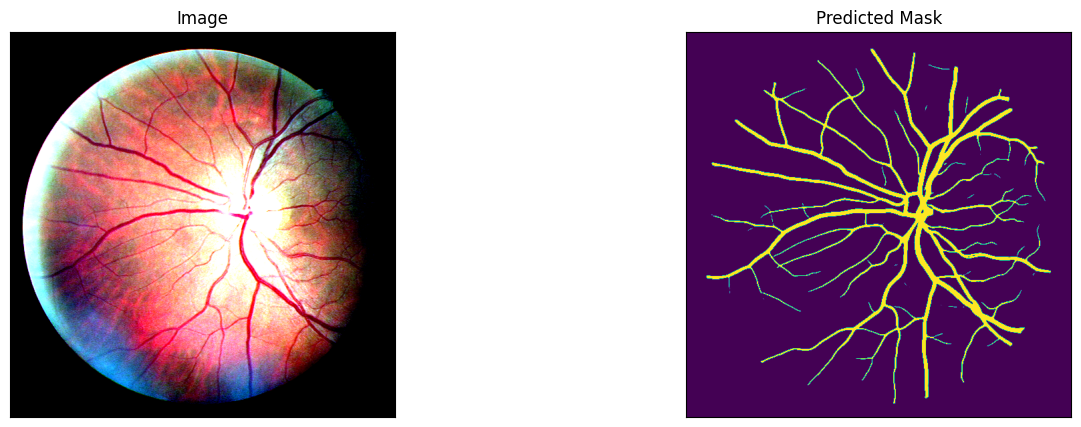

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1
L


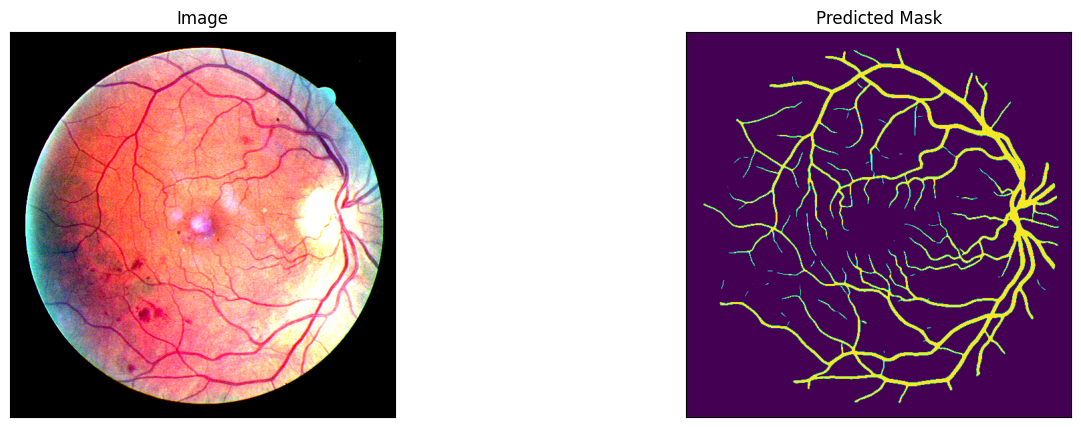

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10
L


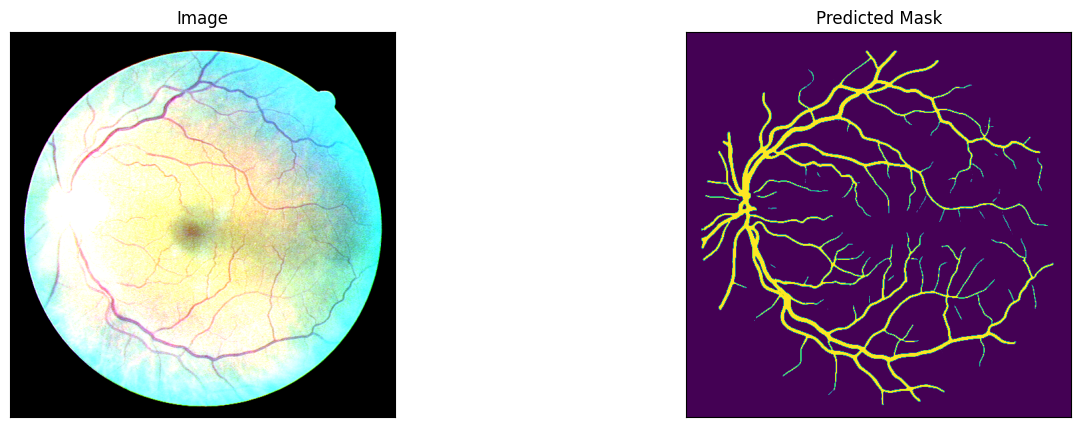

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11
L


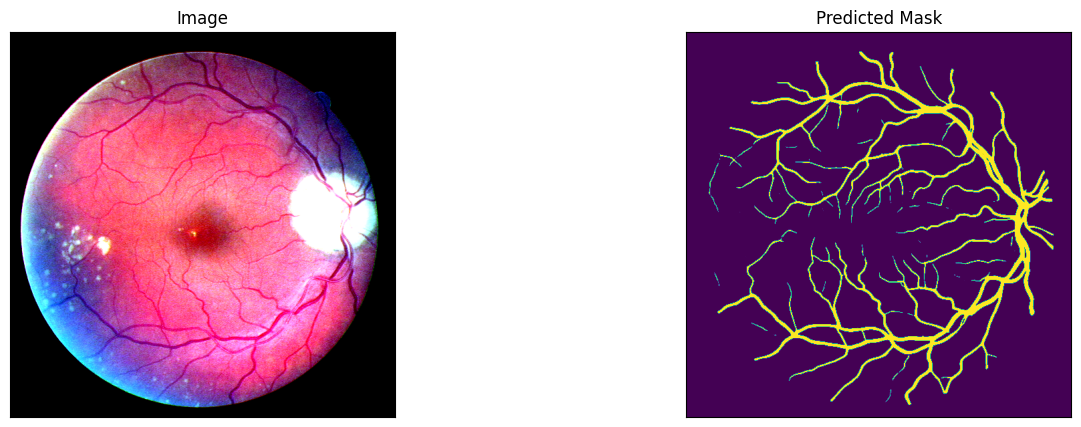

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12
L


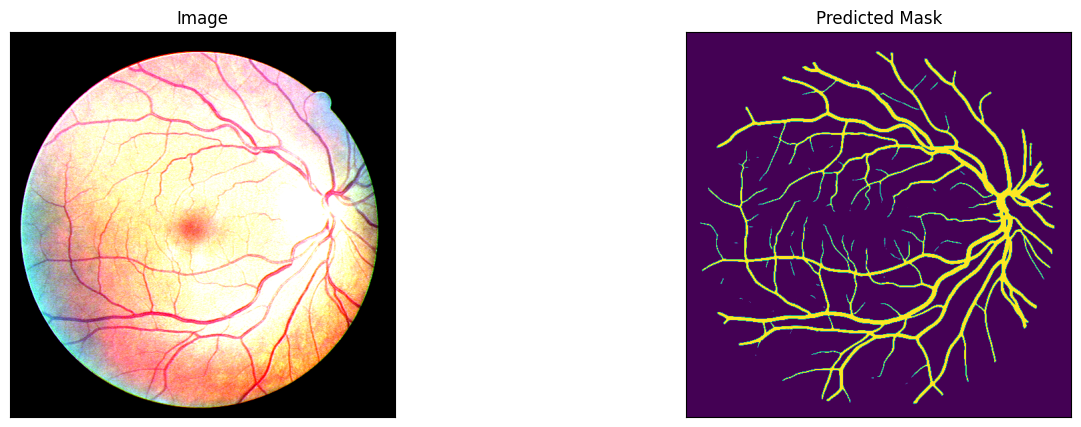

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13
L


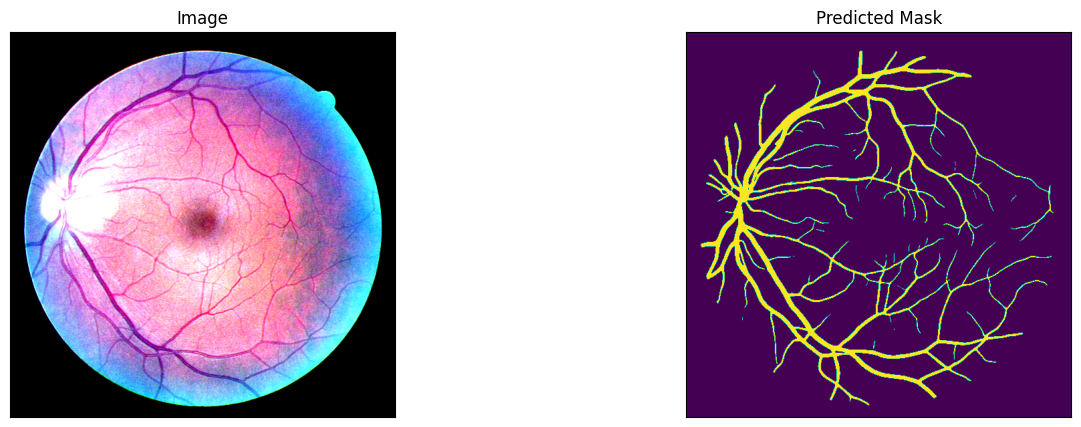

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14
L


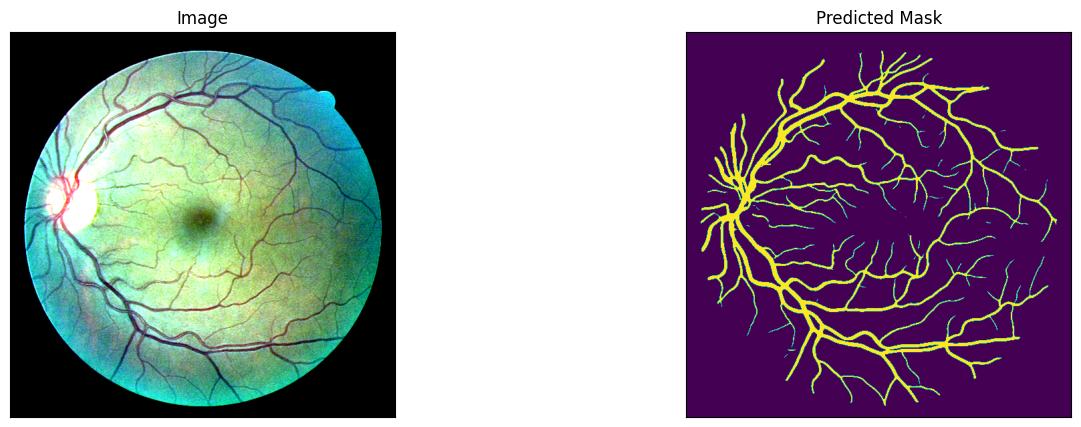

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15
L


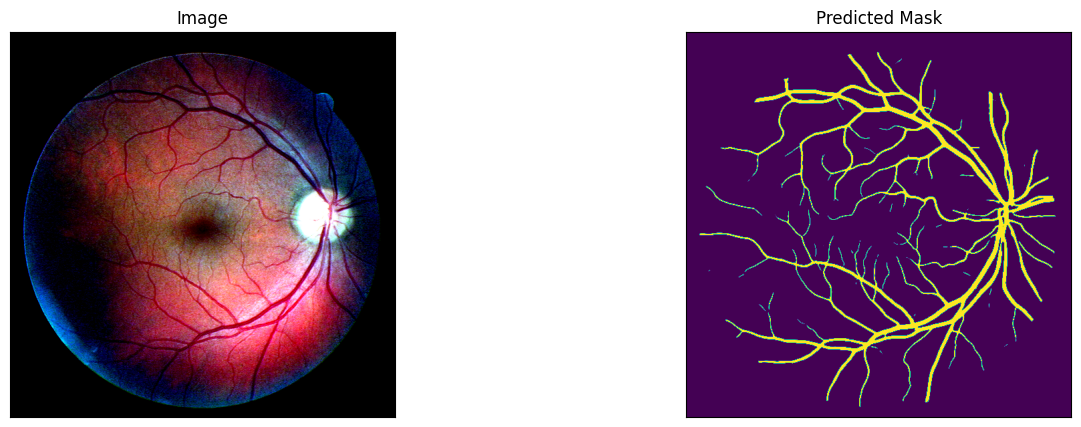

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16
L


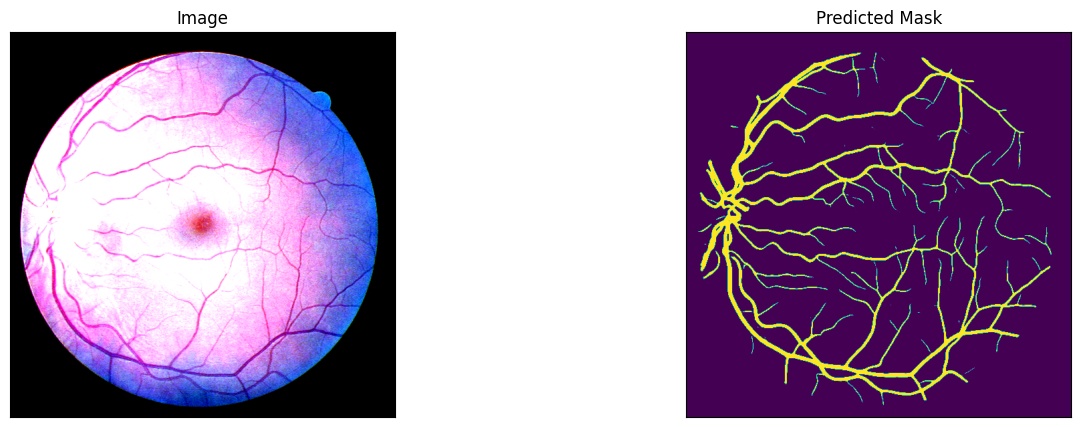

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17
L


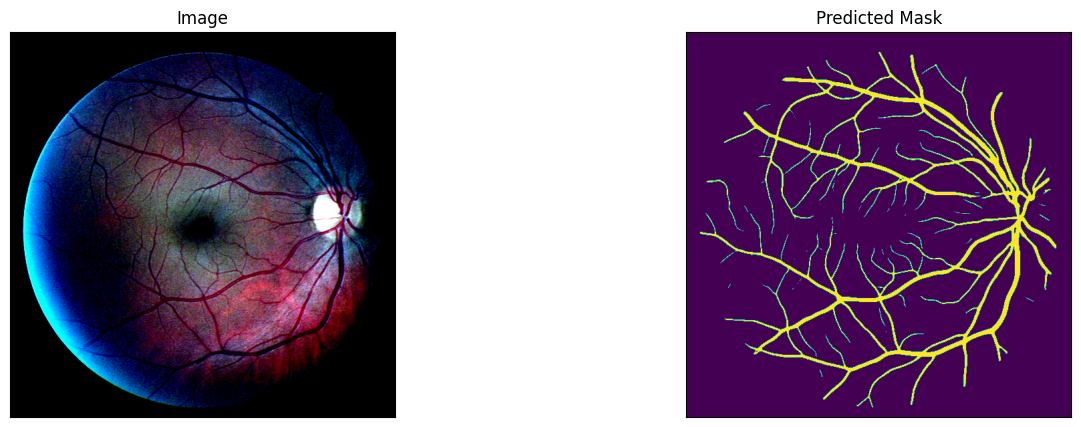

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18
L


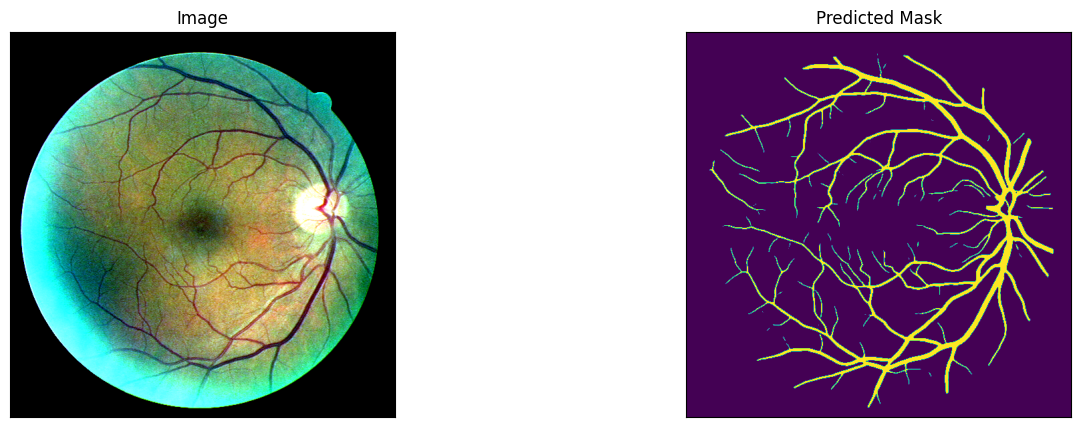

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19
L


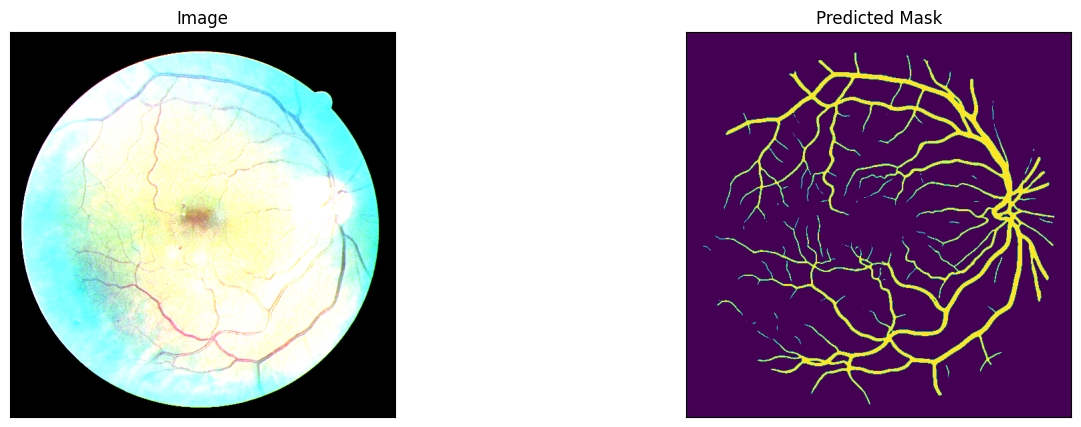

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2
L


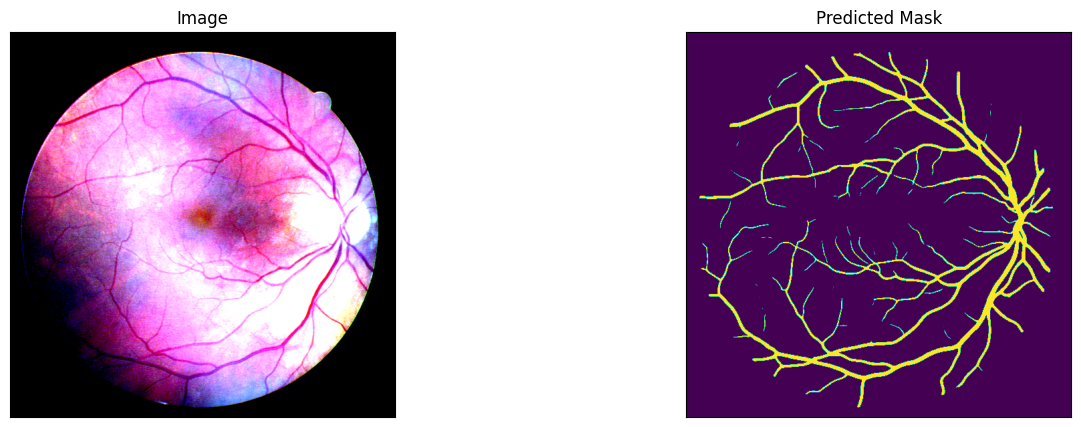

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20
L


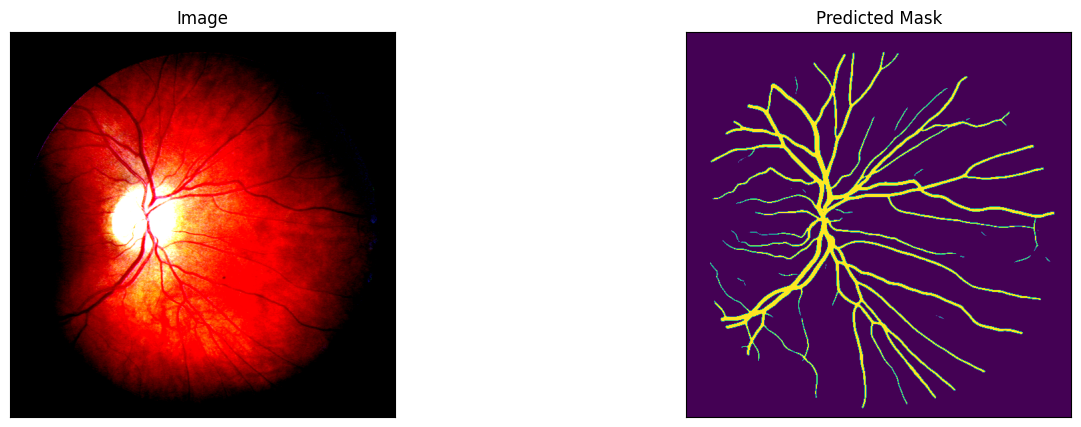

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3
L


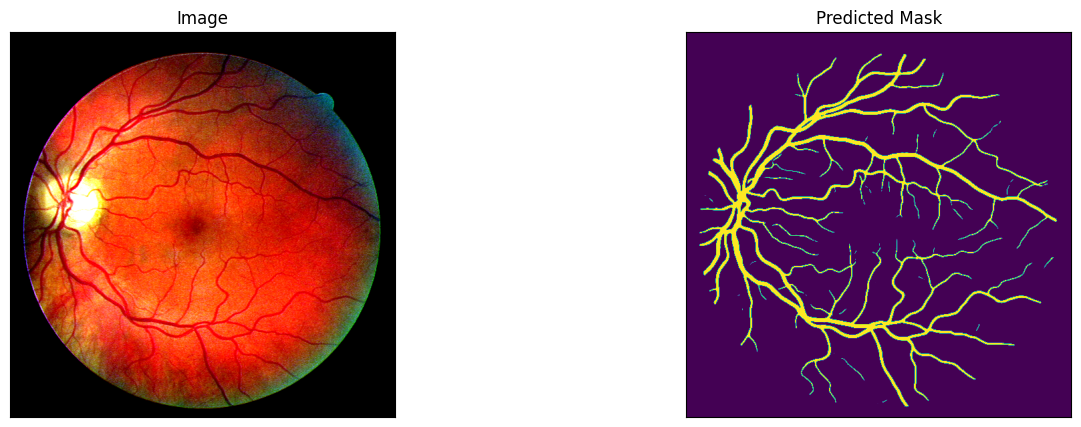

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4
L


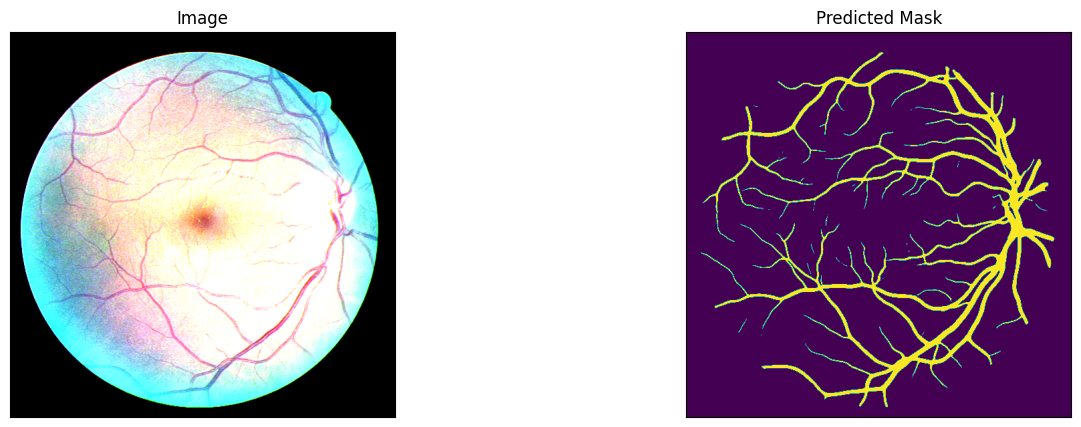

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5
L


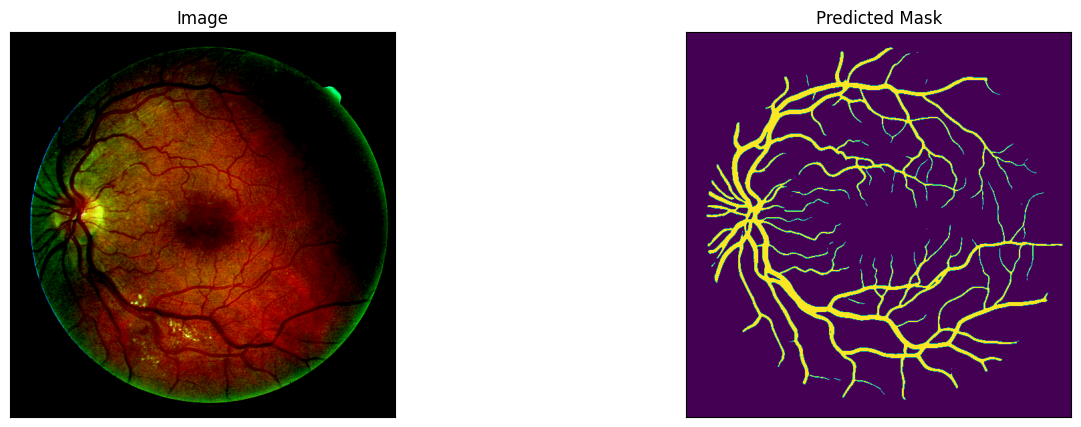

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6
L


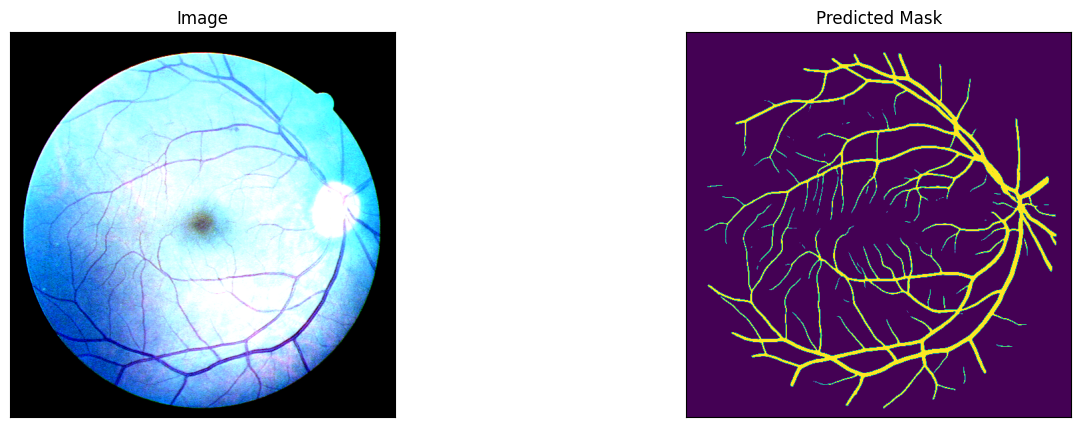

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7
L


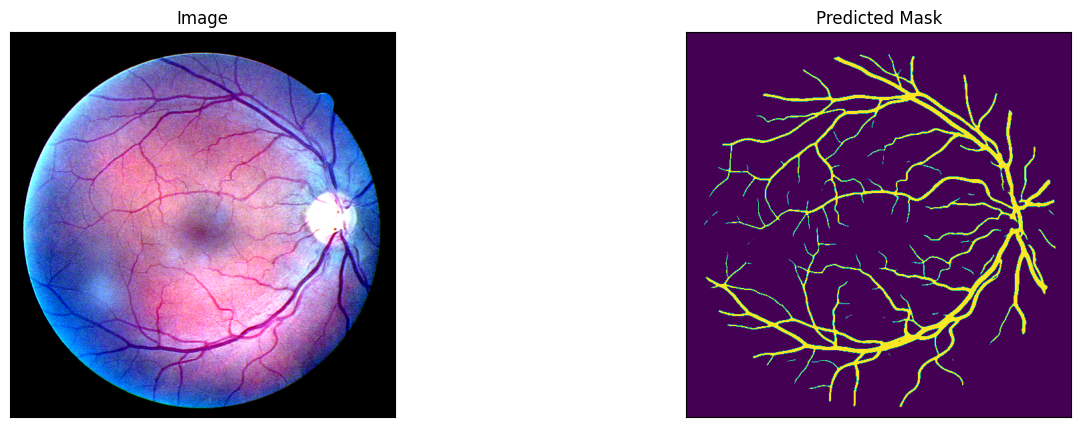

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8
L


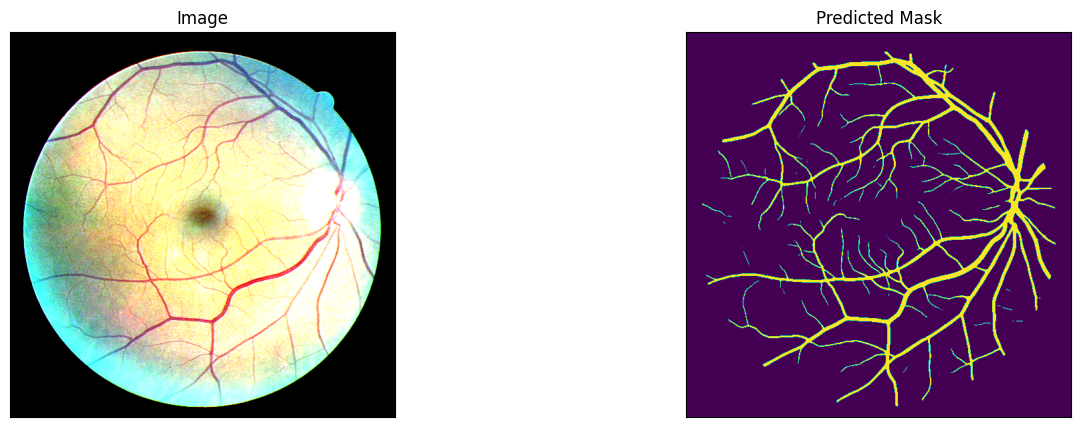

9


In [31]:
import torchvision
num = 20
image_list=[]
name_list=[]
for n in range(num):
    image, _ = test_dataset[n]
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

    pr_mask = best_model.predict(x_tensor).squeeze(0)
    #tensortoPILimage
    pr_mask=torchvision.transforms.ToPILImage()(pr_mask)
    #查看PIL图片的通道数
    print(pr_mask.mode)
    #逆to_tensor
    image = image.transpose(1, 2, 0)
    #pr_mask = pr_mask.transpose(1, 2, 0)
    
    visualize(
        image=image, 
        predicted_mask=pr_mask
    )

    #pr_mask上下扩充4个像素
    #pr_mask=cv2.copyMakeBorder(pr_mask, 4,4,0,0,cv2.BORDER_CONSTANT,value=[0])
    #PIL图上下扩充4个像素
    pr_mask = np.array(pr_mask)
    pr_mask = cv2.copyMakeBorder(pr_mask, 4,4,0,0,cv2.BORDER_CONSTANT,value=[0])
    #pr_mask左边裁掉5个像素，右边裁掉6个像素
    pr_mask = pr_mask[:, 5:570]
    #pr_mask = pr_mask[1]
    print(os.path.basename(test_dataset.images_fps[n])[:-4])
    img_save_path = os.path.join('results/unetplusplus-tu-efficientnetv2_rw_t', os.path.basename(test_dataset.images_fps[n])[:-4]+'.jpg')
    cv2.imwrite(img_save_path, pr_mask)
    image_list.append(pr_mask)
    name_list.append(f"{os.path.basename(test_dataset.images_fps[n])}")


In [41]:
import pandas as pd
from PIL import Image
def turn_to_str(image_list):
    outputs = []
    for image in image_list:
        #transform = torchvision.transforms.ToTensor()
        image=Image.fromarray(image).convert('L')
        image = image.resize((512, 512), Image.Resampling.BILINEAR)
        #image = transform(image)
        image = np.array(image)
        image[image > 5] = 255
        dots = np.where(image.flatten() == 255)[0]
        run_lengths = []
        prev = -2
        for b in dots:
            if (b > prev + 1):
                run_lengths.extend((b + 1, 0))
            run_lengths[-1] += 1
            prev = b
        output = ' '.join([str(r) for r in run_lengths])
        outputs.append(output)
    return outputs

def save_to_csv(name_list, str_list):
    df = pd.DataFrame(columns=['Id', 'Predicted'])
    df['Id'] = [i.split('.')[0] for i in name_list]
    df['Predicted'] = str_list
    df.to_csv(f'results/best_{model.name}_{IN_CHANNELS[0]}.csv', index=None)

str_list = turn_to_str(image_list)
save_to_csv(name_list, str_list)

In [42]:
import PIL.Image as Image
import numpy as np
import cv2
gt_mask=Image.open("test/imagepng/2.png")
pr_mask=Image.open("results/unetplusplus-tu-efficientnetv2_rw_t/2.jpg").convert('L')
#pr有数值部分变为绿色
pr_mask=np.array(pr_mask)
# #统计pr_mask中各个像素值的个数
unique, counts = np.unique(pr_mask, return_counts=True)
print(dict(zip(unique, counts)))

#pr_mask=pr_mask/255
#pr_mask大于0的变为255
pr_mask[pr_mask>5]=255
pr_mask[pr_mask!=255]=0
#对pr_mask中的数值进行sigmoid
# pr_mask=1/(1+np.exp(-pr_mask))
# #大于0.5的变为255，小于0.5的变为0
# pr_mask[pr_mask>=0.5]=255
# pr_mask[pr_mask<0.5]=0
# #统计pr_mask中各个像素值的个数
# unique, counts = np.unique(pr_mask, return_counts=True)
# print(dict(zip(unique, counts)))
#pr_mask[pr_mask]=200
#转为三通道
pr_mask=np.stack((pr_mask*0,pr_mask,pr_mask*0),axis=2)
pr_mask=Image.fromarray(pr_mask)
#叠加两张图，pr_mask为上层图
gt_mask=Image.blend(gt_mask,pr_mask,0.3)
gt_mask.show()

{0: 273919, 1: 11779, 2: 7366, 3: 3670, 4: 1535, 5: 640, 6: 190, 7: 99, 8: 63, 9: 41, 10: 38, 11: 36, 12: 32, 13: 40, 14: 28, 15: 17, 16: 30, 17: 24, 18: 20, 19: 27, 20: 17, 21: 17, 22: 19, 23: 16, 24: 22, 25: 10, 26: 12, 27: 17, 28: 15, 29: 21, 30: 6, 31: 9, 32: 12, 33: 11, 34: 11, 35: 23, 36: 14, 37: 10, 38: 9, 39: 10, 40: 17, 41: 8, 42: 14, 43: 13, 44: 12, 45: 10, 46: 10, 47: 10, 48: 11, 49: 6, 50: 8, 51: 10, 52: 11, 53: 9, 54: 6, 55: 10, 56: 8, 57: 8, 58: 15, 59: 3, 60: 11, 61: 9, 62: 12, 63: 8, 64: 12, 65: 12, 66: 5, 67: 4, 68: 15, 69: 6, 70: 8, 71: 6, 72: 7, 73: 5, 74: 9, 75: 7, 76: 7, 77: 9, 78: 7, 79: 6, 80: 3, 81: 10, 82: 4, 83: 6, 84: 5, 85: 7, 86: 5, 87: 7, 88: 7, 89: 6, 90: 5, 91: 7, 93: 9, 94: 6, 95: 5, 96: 5, 97: 5, 98: 7, 99: 8, 100: 4, 101: 11, 102: 4, 103: 5, 104: 7, 105: 6, 106: 7, 107: 3, 108: 5, 109: 5, 110: 7, 111: 7, 112: 5, 113: 5, 114: 8, 115: 6, 116: 14, 117: 8, 118: 7, 119: 5, 120: 5, 121: 7, 122: 7, 123: 4, 124: 7, 125: 6, 126: 4, 127: 7, 128: 11, 129: 8, 130

In [34]:
#可视化分割结果
#原图
image=Image.open("test/image/20.jpg")
#真值
pr_mask=Image.open("results/unetplusplus-tu-efficientnetv2_rw_t/20.jpg")
#叠加两张图，pr_mask有值的地方为绿色
pr_mask=np.array(pr_mask)
pr_mask[pr_mask[:,:,0]==255]=[0,255,0]
pr_mask=Image.fromarray(pr_mask)
#叠加两张图，pr_mask为上层图
image=Image.blend(image,pr_mask,1)
image.show()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed